In [4]:
pip install numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random

def visualize_hetero_graph(graph):
    G = nx.Graph()

    # 添加用户节点
    for i in range(graph['user'].x.shape[0]):
        G.add_node(f'U{i}', bipartite=0)

    # 添加地点节点
    for i in range(graph['place'].x.shape[0]):
        G.add_node(f'P{i}', bipartite=1)

    # 添加边
    edge_index = graph['user', 'place'].edge_index
    for i in range(edge_index.shape[1]):
        user = f'U{edge_index[0, i].item()}'
        place = f'P{edge_index[1, i].item()}'
        G.add_edge(user, place)

    edge_attr = graph['user', 'place'].edge_attr
    weights = []
    for i in range(edge_index.shape[1]):
        weights.append(edge_attr[i].item())
    max_weight = max(weights)
    min_weight = min(weights)
    normalized_weights = [(w - min_weight) / (max_weight - min_weight) * 4 + 1 for w in weights]

    # 设置布局
    pos = nx.spring_layout(G, iterations=10, k=0.1)

    # 绘制节点
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node.startswith('U')], 
                           node_color='lightblue', node_size=300, label='Users')
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node.startswith('P')], 
                           node_color='lightgreen', node_size=300, label='Places')

    # 绘制边
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=normalized_weights)

    # 添加标签
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title("Heterogeneous Graph: Users and Places")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig4.jpg", dpi=600, bbox_inches='tight')
    plt.show()

## 构建异质图

In [219]:
import pandas as pd
import torch
from collections import defaultdict
from torch_geometric.data import HeteroData
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from datetime import datetime, timedelta
import numpy as np
import warnings
import os
import geohash2
import random
from gensim.models import Word2Vec
import numpy as np

warnings.filterwarnings('ignore')

# 读取数据
df_place = pd.read_csv('D:/研究生/03Phd/segregation/shanghai/shanghai_weibo2.csv', encoding='gbk')
df_user = pd.read_csv('D:/研究生/03Phd/segregation/shanghai/user_info2.csv', encoding='gbk')

# 对类别特征进行编码，但保存原始标签
le = LabelEncoder()
categorical_cols = ['city', 'gender', 'age_label', 'SES']
original_labels = {}
for col in categorical_cols:
    if col in df_user.columns:
        original_labels[col] = df_user[col].copy()
        df_user[col] = le.fit_transform(df_user[col])
        original_labels[f'{col}_decoder'] = dict(zip(range(len(le.classes_)), le.classes_))

# 为df_place添加category列的编码
if 'category' in df_place.columns:
    original_labels['category'] = df_place['category'].copy()
    df_place['category'] = le.fit_transform(df_place['category'])
    original_labels['category_decoder'] = dict(zip(range(len(le.classes_)), le.classes_))

# 过滤掉出现次数小于2次的地点
place_counts = df_place['place'].value_counts()
valid_places = place_counts[place_counts > 2].index
df_place = df_place[df_place['place'].isin(valid_places)]

def geohash_encode(lat, lng, precision=6):
    return geohash2.encode(lat, lng, precision)

def create_geohash_embeddings(geohashes, embedding_dim=8):
    sequences = [[char for char in geohash] for geohash in geohashes]
    model = Word2Vec(sequences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    embeddings = np.array([np.mean([model.wv[char] for char in geohash], axis=0) for geohash in geohashes])
    return embeddings

def calculate_relative_position(lat, lng, center_lat=31.2304, center_lng=121.4737):
    """计算相对于上海市中心的位置"""
    return lat - center_lat, lng - center_lng

def calculate_user_user_edges(df_place, user_mapping, hours):
    df_place['create_time'] = pd.to_datetime(df_place['create_time'])
    user_visits = defaultdict(list)
    for _, row in df_place.iterrows():
        user_visits[row['user_id']].append((row['place'], row['create_time']))
    
    time_threshold = timedelta(hours=hours)
    user_user_edges = set()
    
    for user1, visits1 in user_visits.items():
        for user2, visits2 in user_visits.items():
            if user1 < user2:  # 避免重复边
                for place1, time1 in visits1:
                    for place2, time2 in visits2:
                        if place1 == place2 and abs(time1 - time2) <= time_threshold:
                            user_user_edges.add((user_mapping[user1], user_mapping[user2]))
                            break
                    if (user_mapping[user1], user_mapping[user2]) in user_user_edges:
                        break
    return list(user_user_edges)

def save_user_user_edges(df_place, user_mapping, hours_list):
    for hours in hours_list:
        file_path = f'user_user_edges_hours_{hours}.pt'
        if os.path.exists(file_path):
            print(f"File {file_path} already exists. Skipping save.")
            continue
        user_user_edges = calculate_user_user_edges(df_place, user_mapping, hours)
        torch.save(torch.tensor(user_user_edges, dtype=torch.long), file_path)
        print(f"Edges for {hours} hours saved to {file_path}")

def load_edges(hours):
    file_path = f'user_user_edges_hours_{hours}.pt'
    if os.path.exists(file_path):
        user_user_edges = torch.load(file_path)
        print(f"Edges loaded from {file_path}")
        return user_user_edges
    else:
        print(f"No edge file found for {hours} hours.")
        return None

def build_hetero_graph(df_place, df_user):
    data = HeteroData()

    # 用户节点特征处理
    user_features = df_user[['user_id', 'gender', 'age_label', 'SES']]
    
    # One-hot 编码
    onehot_encoder = OneHotEncoder(sparse_output=False)
    user_onehot = onehot_encoder.fit_transform(user_features[['age_label', 'SES']])   #['gender', 'age_label', 'SES']
    data['user'].x = torch.tensor(user_onehot, dtype=torch.float)
    user_mapping = {id: i for i, id in enumerate(user_features['user_id'])}
    # 添加 node_id 属性
    data['user'].node_id = torch.arange(len(user_mapping), dtype=torch.long)

    # 地点节点特征处理
    place_features = df_place.groupby('place')[['lng', 'lat', 'category']].first().reset_index()
    category_onehot = onehot_encoder.fit_transform(place_features[['category']])
    place_features['geohash'] = place_features.apply(lambda row: geohash_encode(row['lat'], row['lng']), axis=1)
    geohash_embeddings = create_geohash_embeddings(place_features['geohash'])
    place_features['rel_lat'], place_features['rel_lng'] = zip(*place_features.apply(
                    lambda row: calculate_relative_position(row['lat'], row['lng']), axis=1
                                                                            ))
    # 组合经度、纬度和 category 的 one-hot 编码
    place_features_combined = np.hstack([
        place_features[['rel_lat', 'rel_lng']].values, 
        category_onehot,
        geohash_embeddings  # 添加地理哈希嵌入
    ])
    data['place'].x = torch.tensor(place_features_combined, dtype=torch.float)
    place_mapping = {place: i for i, place in enumerate(place_features['place'])}
    # 添加 node_id 属性
    data['place'].node_id = torch.arange(len(place_mapping), dtype=torch.long)

    # 计算边的权重（访问次数）
    edge_weights = df_place.groupby(['user_id', 'place']).size().reset_index(name='weight')
    edge_weights['user_index'] = edge_weights['user_id'].map(user_mapping)
    edge_weights['place_index'] = edge_weights['place'].map(place_mapping)
    scaler = MinMaxScaler()
    edge_weights['normalized_weight'] = scaler.fit_transform(edge_weights[['weight']])

    # 用户-地点边
    user_indices = edge_weights['user_index'].tolist()
    place_indices = edge_weights['place_index'].tolist()
    data['user', 'place'].edge_index = torch.tensor([user_indices, place_indices], dtype=torch.long)
    data['user', 'place'].edge_attr = torch.tensor(edge_weights['normalized_weight'].values, dtype=torch.float)

    return data, user_features, place_features

graph, user_features, place_features = build_hetero_graph(df_place, df_user)

# 计算和保存用户-用户边
hours_list = [0.5, 1, 2, 3, 4, 5]
save_user_user_edges(df_place, {id: i for i, id in enumerate(user_features['user_id'])}, hours_list)

hours_to_load = 5   # 加载 2 小时的用户-用户边
user_user_edges = load_edges(hours_to_load)
if user_user_edges is not None:
    graph['user', 'to', 'user'].edge_index = user_user_edges.t()

graph

File user_user_edges_hours_0.5.pt already exists. Skipping save.
File user_user_edges_hours_1.pt already exists. Skipping save.
File user_user_edges_hours_2.pt already exists. Skipping save.
File user_user_edges_hours_3.pt already exists. Skipping save.
File user_user_edges_hours_4.pt already exists. Skipping save.
File user_user_edges_hours_5.pt already exists. Skipping save.
Edges loaded from user_user_edges_hours_5.pt


HeteroData(
  user={
    x=[11392, 7],
    node_id=[11392],
  },
  place={
    x=[4883, 26],
    node_id=[4883],
  },
  (user, to, place)={
    edge_index=[2, 47565],
    edge_attr=[47565],
  },
  (user, to, user)={ edge_index=[2, 31963] }
)

### time

In [220]:
###visual samples
# visualize_hetero_graph(graph)

In [221]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit
from typing import Union, Tuple, List
import torch_geometric.transforms as T


### 自定义一个函数，可以设置seed，确保每次实验结果的一致性
class SeededRandomLinkSplit(RandomLinkSplit):
    def __init__(self, edge_types: Union[List[str], str], *args, seed: int = None, **kwargs):
        super().__init__(edge_types=edge_types, *args, **kwargs)
        self.seed = seed

    def forward(
        self,
        data: HeteroData,
    ) -> Tuple[HeteroData, HeteroData, HeteroData]:
        if self.seed is not None:
            rng_state = torch.get_rng_state()
            if torch.cuda.is_available():
                cuda_rng_state = torch.cuda.get_rng_state()

            torch.manual_seed(self.seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(self.seed)

        result = super().forward(data)

        if self.seed is not None:
            torch.set_rng_state(rng_state)
            if torch.cuda.is_available():
                torch.cuda.set_rng_state(cuda_rng_state)

        return result

##################输入图
to_undirected = T.ToUndirected()
graph = to_undirected(graph)

# 使用 SeededRandomLinkSplit 而不是 RandomLinkSplit
transform = SeededRandomLinkSplit(
    num_val=0.1,  # 10% 的边用于验证
    num_test=0.1,  # 10% 的边用于测试
    is_undirected=True,
    disjoint_train_ratio=0.3,  # 70% 的边用于消息传递，30% 的边用于监督
    neg_sampling_ratio=2.0,  # 固定负样本的比例为 2:1
    add_negative_train_samples=True,  # 在训练集中添加负样本
    edge_types=[("user", "to", "place")],  # 注意这里需要是一个列表
    rev_edge_types=[("place", "rev_to", "user")],  # 注意这里需要是一个列表
    seed=42  # 设置随机种子
)

train_data, val_data, test_data = transform(graph)
train_data

HeteroData(
  user={
    x=[11392, 7],
    node_id=[11392],
  },
  place={
    x=[4883, 26],
    node_id=[4883],
  },
  (user, to, place)={
    edge_index=[2, 26638],
    edge_attr=[26638],
    edge_label=[34245],
    edge_label_index=[2, 34245],
  },
  (user, to, user)={ edge_index=[2, 63926] },
  (place, rev_to, user)={
    edge_index=[2, 26638],
    edge_attr=[26638],
  }
)

## GNN模块

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch_sparse
from torch import Tensor
from torch_geometric.nn import (SAGEConv, GATConv, HeteroConv, HGTConv, RGCNConv, HANConv, GraphConv, to_hetero, GCNConv)
from torch_geometric.data import HeteroData

################################################################
# Encoder classes
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, add_self_loops=False, dropout=dropout)
        self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False, dropout=dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class HGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, metadata, dropout=0.2):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        })
        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        })
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata, num_heads)
            self.convs.append(conv)
        self.lins = torch.nn.ModuleDict({
            node_type: torch.nn.Linear(hidden_channels, hidden_channels)
            for node_type in metadata[0]
        })
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {node_type: self.lins[node_type](x) for node_type, x in x_dict.items()}

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, num_relations, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = RGCNConv(in_channels, hidden_channels, num_relations)
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = F.relu(self.dropout(x))
        return self.lin(x)

class HAN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HANConv(in_channels, hidden_channels, metadata, heads=4, dropout=dropout)
            self.convs.append(conv)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {key: self.lin(x) for key, x in x_dict.items()}
    
class HG_SM(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, num_layers, metadata, dropout=0.2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata, num_heads)
            self.convs.append(conv)
        self.lins = torch.nn.ModuleDict({
            node_type: torch.nn.Linear(hidden_channels, hidden_channels)
            for node_type in metadata[0]
        })
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(self.dropout(x)) for key, x in x_dict.items()}
        return {node_type: self.lins[node_type](x) for node_type, x in x_dict.items()}

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

################################################################
# user infomation updating
class OptimalPropagationModule(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.attention = torch.nn.Linear(hidden_channels, 1)
    
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        row, col = edge_index
        attention_scores = self.attention(x[row])
        attention_weights = F.softmax(attention_scores, dim=0)
        x_propagated = torch.zeros_like(x)
        x_propagated.index_add_(0, col, attention_weights * x[row])
        return x_propagated
    
class GCN2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5, sample_size=100000, seed=42):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.optimal_propagation = OptimalPropagationModule(hidden_channels)
        self.sample_size = sample_size
        self.seed = seed

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # 设置随机种子
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)

        # 对边进行采样
        if edge_index.size(1) > self.sample_size:
            perm = torch.randperm(edge_index.size(1))[:self.sample_size]
            edge_index = edge_index[:, perm]  
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.optimal_propagation(x, edge_index)
        return x
    
################################################################
# Decoder class
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.classifier = torch.nn.Linear(hidden_channels * 2, 1)

    def forward(self, user_x, place_x, edge_index):
        edge_feat = torch.cat([user_x[edge_index[0]], place_x[edge_index[1]]], dim=-1)
        return self.classifier(edge_feat).squeeze(-1)
    
class MLPEdgeDecoder(nn.Module):
    def __init__(self, hidden_channels, mlp_hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels * 2, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, 1)
        )

    def forward(self, user_x, place_x, edge_index):
        edge_feat = torch.cat([user_x[edge_index[0]], place_x[edge_index[1]]], dim=-1)
        return self.mlp(edge_feat).squeeze(-1)

###############################################################
# Complete Model
class Model(torch.nn.Module):
    def __init__(self, graph: HeteroData, hidden_channels, out_channels, 
                 gnn_type='SAGE', num_layers=2, seed=42, consider_user_user=False):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.seed = seed
        self.consider_user_user = consider_user_user

        # 设置全局随机种子
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)

        self.node_embeddings = torch.nn.ModuleDict()
        for node_type in graph.node_types:
            num_nodes = graph[node_type].num_nodes
            self.node_embeddings[node_type] = torch.nn.Embedding(num_nodes, hidden_channels)
        
        self.node_transforms = torch.nn.ModuleDict()
        for node_type in graph.node_types:
            if hasattr(graph[node_type], 'x'):
                in_channels = graph[node_type].x.size(1)
                self.node_transforms[node_type] = torch.nn.Linear(in_channels, hidden_channels)
        
        # 用于user-user关系的GCN
        if self.consider_user_user:
            self.user_encoder = GCN2(hidden_channels, hidden_channels, sample_size=100000, seed=self.seed)

        if gnn_type == 'SAGE':
            self.encoder = to_hetero(SAGE(hidden_channels, hidden_channels), graph.metadata())
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'GAT':
            self.encoder = to_hetero(GAT(hidden_channels, hidden_channels), graph.metadata())
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'HGCNN':
            self.encoder = HGCNN(hidden_channels, hidden_channels, graph.metadata())
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'HGT':
            self.encoder = HGT(hidden_channels, num_heads=4, num_layers=num_layers, metadata=graph.metadata())
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'RGCN':
            num_relations = len(graph.edge_types)
            self.encoder = RGCN(hidden_channels, hidden_channels, num_layers, num_relations)
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'HAN':
            self.encoder = HAN(hidden_channels, hidden_channels, out_channels, num_layers, graph.metadata())
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'GCN':
            self.encoder = to_hetero(GCN(hidden_channels, hidden_channels), graph.metadata())
            self.decoder = EdgeDecoder(hidden_channels)
        elif gnn_type == 'HG-SM':
            self.encoder = HG_SM(hidden_channels, num_heads=4, num_layers=num_layers, metadata=graph.metadata())
            self.decoder = MLPEdgeDecoder(hidden_channels)


    def forward(self, graph: HeteroData) -> Tensor:
        # 设置随机种子
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)
        
        # 初始化节点特征
        x_dict = {}
        for node_type in graph.node_types:
            x = self.node_embeddings[node_type](graph[node_type].node_id)
            if node_type in self.node_transforms:
                x = x + self.node_transforms[node_type](graph[node_type].x)
            x_dict[node_type] = x

        # 使用采样的GCN编码器处理用户特征（如果考虑user-user关系）
        if self.consider_user_user:
            user_edge_index = graph['user', 'to', 'user'].edge_index
            x_dict['user'] = self.user_encoder(x_dict['user'], user_edge_index)

        # 使用选定的编码器处理整个异构图
        if isinstance(self.encoder, RGCN):
            edge_index, edge_type = self.prepare_edges(graph)
            x = torch.cat([x_dict[node_type] for node_type in graph.node_types])
            x = self.encoder(x, edge_index, edge_type)
            
            # 将结果分配回各个节点类型
            start = 0
            for node_type in graph.node_types:
                num_nodes = graph[node_type].num_nodes
                x_dict[node_type] = x[start:start + num_nodes]
                start += num_nodes
        else:
            x_dict = self.encoder(x_dict, graph.edge_index_dict)

        # 预测user-place连接
        user_x = x_dict['user']
        place_x = x_dict['place']
        edge_index = graph['user', 'to', 'place'].edge_label_index

        return self.decoder(user_x, place_x, edge_index)

    def prepare_edges(self, graph: HeteroData):
        edge_index_list = []
        edge_type_list = []
        for i, (src, edge_type, dst) in enumerate(graph.edge_types):
            edge_index = graph[src, edge_type, dst].edge_index
            edge_index_list.append(edge_index)
            edge_type_list.append(torch.full((edge_index.size(1),), i, dtype=torch.long))
        edge_index = torch.cat(edge_index_list, dim=1)
        edge_type = torch.cat(edge_type_list)
        return edge_index, edge_type

## 训练模块

In [223]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc
import numpy as np

def train_model(model, train_data, optimizer, criterion, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data = train_data.to(device)
    
    losses = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        target = train_data["user", "to", "place"].edge_label
        loss = criterion(pred, target.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    return losses, model

# gnn_types = ['SAGE', 'GAT', 'HGCNN', 'RGCN', 'HAN', 'EEGNN']
gnn_types = ['HG-SM']
all_losses = {}
all_models = {}

for gnn_type in gnn_types:
    print(f"Training {gnn_type} model...")
    model = Model(graph=train_data, hidden_channels=64, out_channels=64, gnn_type=gnn_type, consider_user_user=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    losses, trained_model = train_model(model, train_data, optimizer, criterion, 100)
    all_losses[gnn_type] = losses
    all_models[gnn_type] = trained_model

Training HG-SM model...
Epoch: 010, Loss: 0.6807
Epoch: 020, Loss: 0.6382
Epoch: 030, Loss: 0.6342
Epoch: 040, Loss: 0.6279
Epoch: 050, Loss: 0.6164
Epoch: 060, Loss: 0.6030
Epoch: 070, Loss: 0.5891
Epoch: 080, Loss: 0.5568
Epoch: 090, Loss: 0.5191
Epoch: 100, Loss: 0.4782


In [224]:
from sklearn.metrics import roc_auc_score

for gnn_type, model in all_models.items():
    model.eval()
    with torch.no_grad():
        pred = model(test_data)
        pred = pred.cpu().numpy()
        target = test_data["user", "to", "place"].edge_label.cpu().numpy()
        auc = roc_auc_score(target, pred)
        print(f'{auc:.3f}')

0.818


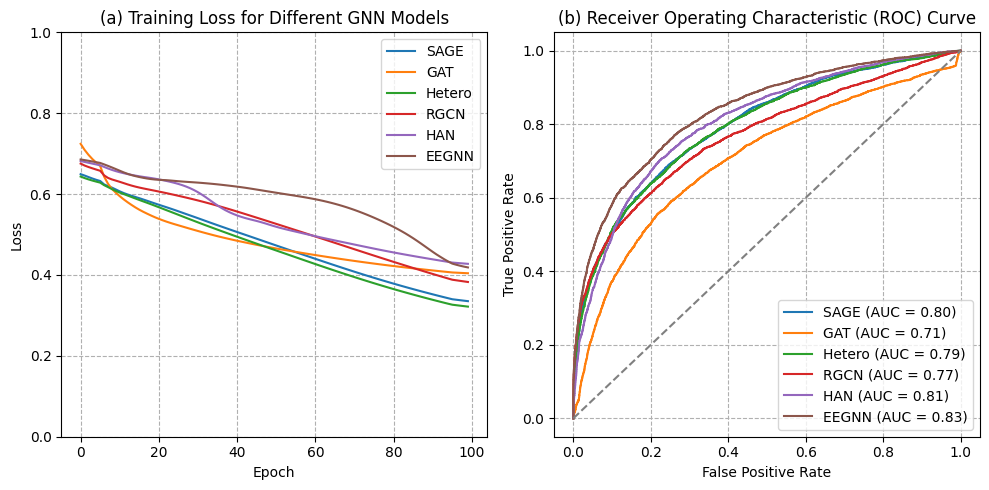

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def smooth_curve(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

window_size = 10  # 移动平均窗口大小，可以根据需要调整
excluded_model = 'HGT'  # 指定要排除的模型名称

for gnn_type, losses in all_losses.items():
    if gnn_type != excluded_model:
        losses_series = pd.Series(losses)
        smoothed_losses = losses_series.rolling(window=window_size, center=True, min_periods=1).mean()
        plt.plot(smoothed_losses, label=f'{gnn_type}')

plt.ylim(0, 1)  # 您可以根据需要调整这里的值
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('(a) Training Loss for Different GNN Models')
plt.legend()
plt.grid(True, linestyle="--")


# 计算和绘制ROC曲线
plt.subplot(1, 2, 2)
for gnn_type, model in all_models.items():
    if gnn_type != excluded_model:
        model.eval()
        with torch.no_grad():
            pred = model(test_data)
            target = test_data["user", "to", "place"].edge_label
            pred_np = pred.cpu().numpy()
            target_np = target.cpu().numpy()
            
            fpr, tpr, _ = roc_curve(target_np, pred_np)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, label=f'{gnn_type} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(b) Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle="--")

plt.tight_layout()
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig3.jpg", dpi=600, bbox_inches='tight')
plt.show()

## 模型准确度

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score,auc
import torch
import numpy as np

def test(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data)
        pred = pred.cpu().numpy()
        target = data["user", "to", "place"].edge_label.cpu().numpy()
        pred_binary = (pred > 0).astype(int)
        auc = roc_auc_score(target, pred)
        acc = accuracy_score(target, pred_binary)
        f1 = f1_score(target, pred_binary)
        print(f"AUC: {auc:.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        return auc, acc, f1

model.eval()
print("Test set results:")
test(model, val_data)

Test set results:
AUC: 0.8032
Accuracy: 0.7494
F1 Score: 0.6237


(0.8032357847658768, 0.749439304737875, 0.6237238185454163)

In [7]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, auc
import torch
import numpy as np

for gnn_type, model in all_models.items():
        # if gnn_type != excluded_model:
    model.eval()
    with torch.no_grad():
        pred = model(test_data)
        pred = pred.cpu().numpy()
        target = test_data["user", "to", "place"].edge_label.cpu().numpy()
        # pred_binary = (pred > 0).astype(int)
        auc = roc_auc_score(target, pred)
        # acc = accuracy_score(target, pred_binary)
        # roc_auc = auc(fpr, tpr)
        # print(f"Model: {gnn_type}")
        # print(f"AUC: {auc:.4f}")
        # print(f"Accuracy: {acc:.4f}")
        # print(f"F1 Score: {f1:.4f}")
        print(f'{auc:.3f}')

0.802
0.705
0.805
0.743
0.763
0.809


In [20]:
model

Model(
  (node_embeddings): ModuleDict(
    (user): Embedding(11392, 64)
    (place): Embedding(4883, 64)
  )
  (node_transforms): ModuleDict(
    (user): Linear(in_features=9, out_features=64, bias=True)
    (place): Linear(in_features=26, out_features=64, bias=True)
  )
  (user_encoder): GCN2(
    (conv1): GCNConv(64, 64)
    (conv2): GCNConv(64, 64)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder): EEGNN(
    (convs): ModuleList(
      (0-1): 2 x HGTConv(-1, 64, heads=8)
    )
    (lins): ModuleDict(
      (user): Linear(in_features=64, out_features=64, bias=True)
      (place): Linear(in_features=64, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): MLPEdgeDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

##  生成负样本

In [577]:
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from collections import Counter
import random
import numpy as np

def add_negative_samples_hetero(graph, neg_sampling_ratio=1.0, min_edges_per_node=3, seed=None):
    """
    向异构图中添加负样本边，并创建edge_label_index。
    确保每个节点至少有指定数量的边，优先为边数少的节点添加边。
    只为指定的边类型添加负样本。
    
    参数:
    graph (torch_geometric.data.HeteroData): 输入异构图
    neg_sampling_ratio (float): 负样本与正样本的比例，默认为1.0
    min_edges_per_node (int): 每个节点最少应有的边数，默认为3
    seed (int): 随机种子，用于确保结果可重复
    
    返回:
    torch_geometric.data.HeteroData: 添加了负样本的新图
    """
    # 设置随机种子
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

    new_graph = graph.clone()
    
    for edge_type in graph.edge_types:
        # 只为 (user, to, place) 边类型添加负样本
        if edge_type != ('user', 'to', 'place'):
            continue
        
        pos_edge_index = graph[edge_type].edge_index
        src_node_type, _, dst_node_type = edge_type
        
        # 计算每个节点的边数
        src_edge_count = Counter(pos_edge_index[0].tolist())
        dst_edge_count = Counter(pos_edge_index[1].tolist())
        
        num_neg_samples = int(pos_edge_index.size(1) * neg_sampling_ratio)
        
        # 找出需要额外边的节点
        src_nodes_need_edges = [node for node, count in src_edge_count.items() if count < min_edges_per_node]
        dst_nodes_need_edges = [node for node, count in dst_edge_count.items() if count < min_edges_per_node]
        
        # 为需要额外边的节点创建负边
        additional_neg_edges = []
        for src in src_nodes_need_edges:
            for dst in range(graph[dst_node_type].num_nodes):
                if src_edge_count[src] >= min_edges_per_node:
                    break
                if dst not in dst_edge_count or dst_edge_count[dst] < min_edges_per_node:
                    if not ((pos_edge_index[0] == src) & (pos_edge_index[1] == dst)).any():
                        additional_neg_edges.append([src, dst])
                        src_edge_count[src] += 1
                        dst_edge_count[dst] += 1
        
        for dst in dst_nodes_need_edges:
            for src in range(graph[src_node_type].num_nodes):
                if dst_edge_count[dst] >= min_edges_per_node:
                    break
                if src not in src_edge_count or src_edge_count[src] < min_edges_per_node:
                    if not ((pos_edge_index[0] == src) & (pos_edge_index[1] == dst)).any():
                        additional_neg_edges.append([src, dst])
                        src_edge_count[src] += 1
                        dst_edge_count[dst] += 1
        
        # 如果还需要更多负边，使用负采样生成
        remaining_neg_samples = max(0, num_neg_samples - len(additional_neg_edges))
        if remaining_neg_samples > 0:
            remaining_neg_edge_index = negative_sampling(
                edge_index=pos_edge_index,
                num_nodes=(graph[src_node_type].num_nodes, graph[dst_node_type].num_nodes),
                num_neg_samples=remaining_neg_samples,
            )
            additional_neg_edges.extend(remaining_neg_edge_index.t().tolist())
        
        neg_edge_index = torch.tensor(additional_neg_edges).t()
        
        # 创建edge_label_index
        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        
        # 创建边标签：正边为1，负边为0
        edge_label = torch.cat([
            torch.ones(pos_edge_index.size(1)),
            torch.zeros(neg_edge_index.size(1))
        ], dim=0)
        
        # 更新新图的边、边标签和edge_label_index
        new_graph[edge_type].edge_index = pos_edge_index  # 保持原始edge_index不变
        new_graph[edge_type].edge_label = edge_label
        new_graph[edge_type].edge_label_index = edge_label_index
    
    return new_graph

In [578]:
# 使用优化后的函数，并设置随机种子
seed = 42  # 你可以选择任何整数作为种子
graph_samples = add_negative_samples_hetero(graph, neg_sampling_ratio=2.0, min_edges_per_node=10, seed=seed)
graph_samples

HeteroData(
  user={
    x=[11392, 9],
    node_id=[11392],
  },
  place={
    x=[4883, 26],
    node_id=[4883],
  },
  (user, to, place)={
    edge_index=[2, 47565],
    edge_attr=[47565],
    edge_label=[142695],
    edge_label_index=[2, 142695],
  },
  (user, to, user)={ edge_index=[2, 11344] },
  (place, rev_to, user)={
    edge_index=[2, 47565],
    edge_attr=[47565],
  }
)

## 隔离计算

In [611]:
import tqdm
import torch
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

def calculate_gini(probs):
    """计算基尼系数"""
    sorted_probs = np.sort(probs)
    index = np.arange(1, len(probs) + 1)
    n = len(probs)
    return (np.sum((2 * index - n - 1) * sorted_probs)) / (n * np.sum(probs))

from scipy import stats

def composite_segregation_index(df, integration_col, entropy_col, gini_col):
    scaler = MinMaxScaler()
    df['normalized_integration'] = scaler.fit_transform(df[[integration_col]])
    df['normalized_entropy'] = scaler.fit_transform(df[[entropy_col]])
    df['normalized_gini'] = scaler.fit_transform(df[[gini_col]])
    df['reversed_integration'] = 1 - df['normalized_integration']
    df['reversed_entropy'] = 1 - df['normalized_entropy']
    df['composite_integration_index'] = (
        df['reversed_integration'] * 1/3 +
        df['reversed_entropy'] * 1/3 +
        df['normalized_gini'] * 1/3
    )
    return df

def composite_integration_index(df, integration_col, entropy_col, gini_col):
    scaler = MinMaxScaler()
    df['normalized_integration'] = scaler.fit_transform(df[[integration_col]])
    df['normalized_entropy'] = scaler.fit_transform(df[[entropy_col]])
    df['normalized_gini'] = scaler.fit_transform(df[[gini_col]])
    df['reversed_gini'] = 1 - df['normalized_gini']
    # df['reversed_entropy'] = 1 - df['normalized_entropy']
    df['composite_integration_index'] = (
        df['normalized_integration'] * 1/3 +
        df['normalized_entropy'] * 1/3 +
        df['reversed_gini'] * 1/3
    )
    return df

# 收集所有用户与地点之间的连接概率和边索引
user_place_probs, all_edge_index = [], []

with torch.no_grad():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sampled_data = graph_samples.to(device)
    pred = model(sampled_data)
    user_place_probs.append(pred.sigmoid())
    all_edge_index.append(sampled_data['user', 'to', 'place'].edge_index)

all_probs = torch.cat(user_place_probs, dim=0).cpu().numpy()
all_edge_index = torch.cat(all_edge_index, dim=1).cpu().numpy()

# 计算每个用户和地点的隔离指数、熵和基尼系数
user_probs, place_probs = defaultdict(list), defaultdict(list)
for (u, p), prob in zip(all_edge_index.T, all_probs):
    user_probs[u].append(prob)
    place_probs[p].append(prob)

user_segregation_data = {
    'user_id': list(user_probs.keys()),
    'integration_index': [np.mean(probs) for probs in user_probs.values()],
    'entropy': [entropy(np.array(probs) / np.sum(probs)) for probs in user_probs.values()],
    'gini': [calculate_gini(np.array(probs) / np.sum(probs)) for probs in user_probs.values()]
}

place_segregation_data = {
    'place': list(place_probs.keys()),
    'integration_index': [np.mean(probs) for probs in place_probs.values()],
    'entropy': [entropy(np.array(probs) / np.sum(probs)) for probs in place_probs.values()],
    'gini': [calculate_gini(np.array(probs) / np.sum(probs)) for probs in place_probs.values()],
    'avg_connection_strength': [np.std(probs) for probs in place_probs.values()]
}

user_segregation_df = pd.DataFrame(user_segregation_data)
place_segregation_df = pd.DataFrame(place_segregation_data)

# 解码用户和地点信息，并添加原始的性别、年龄和SES信息
user_decoder = dict(zip(user_features.index, user_features['user_id']))
user_info = user_features.set_index('user_id')[['gender', 'age_label', 'SES']]
user_segregation_df['user_id'] = user_segregation_df['user_id'].map(user_decoder)
user_segregation_df = pd.merge(user_segregation_df, user_info, left_on='user_id', right_index=True)
user_segregation_df['gender'] = user_segregation_df['gender'].map(original_labels['gender_decoder'])
user_segregation_df['age_label'] = user_segregation_df['age_label'].map(original_labels['age_label_decoder'])
user_segregation_df['SES'] = user_segregation_df['SES'].map(original_labels['SES_decoder'])

place_decoder = dict(zip(place_features.index, place_features['place']))
place_info = place_features.set_index('place')[['lng', 'lat', 'category']]
place_segregation_df['place'] = place_segregation_df['place'].map(place_decoder)
place_segregation_df = pd.merge(place_segregation_df, place_info, left_on='place', right_index=True)

# if 'category' in categorical_cols:
category_decoder = dict(zip(range(len(le.classes_)), le.classes_))
# print(category_decoder)
place_segregation_df['category'] = place_segregation_df['category'].map(category_decoder)

# 计算综合隔离指数
user_segregation_df = composite_segregation_index(user_segregation_df, 'integration_index', 'entropy', 'gini')
place_segregation_df = composite_integration_index(place_segregation_df, 'integration_index', 'entropy', 'gini')

# 保存隔离指数到CSV
user_segregation_df.to_csv('user_mobility_exposure_seg.csv', index=False)
place_segregation_df.to_csv('place_mobility_exposure_seg.csv', index=False)

print("用户隔离指数已保存到 'user_segregation_indices.csv'")
print("地点隔离指数和平均连接强度已保存到 'place_segregation_and_connection.csv'")

# 打印整体统计信息
print("\n用户隔离指数统计：")
print(user_segregation_df[['integration_index', 'entropy', 'gini']].describe())

print("\n地点隔离指数统计：")
print(place_segregation_df[['integration_index', 'entropy', 'gini', 'avg_connection_strength']].describe())

用户隔离指数已保存到 'user_segregation_indices.csv'
地点隔离指数和平均连接强度已保存到 'place_segregation_and_connection.csv'

用户隔离指数统计：
       integration_index       entropy          gini
count       11104.000000  11104.000000  11104.000000
mean            0.500509      1.005221      0.179882
std             0.231869      0.730907      0.141236
min             0.004987      0.000000      0.000000
25%             0.315610      0.564909      0.023990
50%             0.503824      0.979861      0.188997
75%             0.696245      1.397437      0.291364
max             0.958293      5.586544      0.667560

地点隔离指数统计：
       integration_index      entropy         gini  avg_connection_strength
count        4883.000000  4883.000000  4883.000000              4883.000000
mean            0.223974     1.350233     0.154688                 0.071462
std             0.146554     1.000186     0.098463                 0.059281
min             0.004987     0.000000     0.000000                 0.000000
25%             0.1219

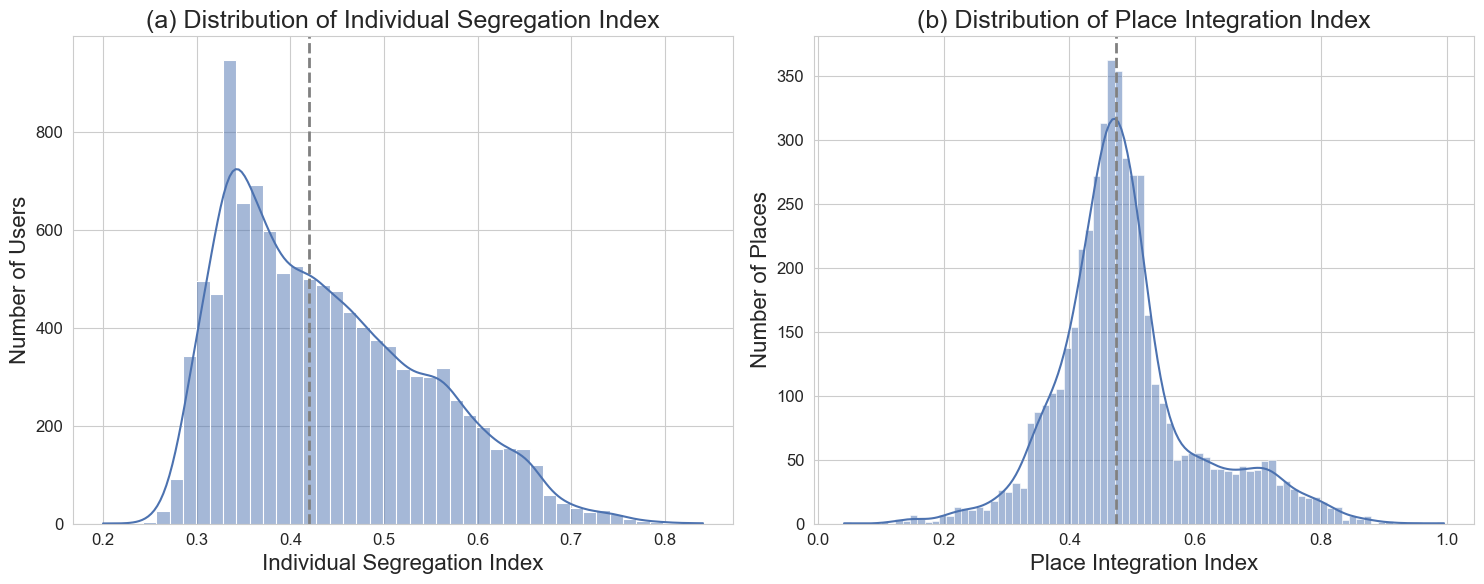

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 设置Seaborn样式
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams.update({'font.size': 12})  # 增加全局字体大小

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 用户隔离指数分布
sns.histplot(data=user_segregation_df, x='composite_integration_index', kde=True, ax=ax1)
ax1.set_xlabel('Individual Segregation Index', fontsize=16)
ax1.set_ylabel('Number of Users', fontsize=16)
ax1.set_title('(a) Distribution of Individual Segregation Index', fontsize=18)
# 添加用户隔离指数的中位数虚线
user_median = user_segregation_df['composite_integration_index'].median()
ax1.axvline(user_median, color='gray', linestyle='--', linewidth=2)
# ax1.text(user_median, ax1.get_ylim()[1], f'Median: {user_median:.2f}', 
#          horizontalalignment='center', verticalalignment='bottom', color='r', fontsize=14)

# 地点隔离指数分布
sns.histplot(data=place_segregation_df, x='composite_integration_index', kde=True, ax=ax2)
ax2.set_xlabel('Place Integration Index', fontsize=16)
ax2.set_ylabel('Number of Places', fontsize=16)
ax2.set_title('(b) Distribution of Place Integration Index', fontsize=18)
place_median = place_segregation_df['composite_integration_index'].median()
ax2.axvline(place_median, color='gray', linestyle='--', linewidth=2)

# 调整布局
plt.tight_layout()
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig0.jpg", dpi=600, bbox_inches='tight')
plt.show()

In [41]:
place_median, user_median

(0.47424714763959247, 0.41942260787647395)

## 隔离统计

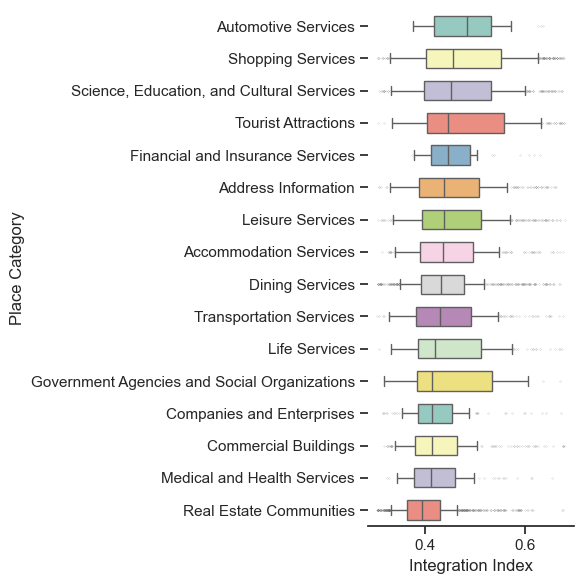

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

sns.set_theme(style="ticks")
palette = sns.color_palette('Set3')

df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ.csv', encoding='gbk')

# var= 'composite_integration_index'
var= '≤0.5h'

# df = df[df[var].ne(0) & df[var].ne(1)]
q_low = df[var].quantile(0.05)
q_hi = df[var].quantile(0.95)
df_clean = df[(df[var] > q_low) & (df[var] < q_hi)]

# 计算每个标签的中位数，并按中位数从大到小排序
median_values = (
    df_clean.groupby("category")[var]
    .median()
    .reset_index()
    .sort_values(by=var, ascending=False)
)

# 将原数据框中的标签列转化为有序类别，按中位数排序
df_clean["category"] = pd.Categorical(
    df_clean["category"], 
    categories=median_values["category"], 
    ordered=True
)

# 按标签排序数据框
filtered_df_sorted = df_clean.sort_values(by="category")

g = sns.catplot(
    data=filtered_df_sorted, 
    kind='box',
    x=var, 
    y="category",  
    errorbar="ci", 
    # alpha=.8,
    height=6, 
    aspect=1,
    palette=palette,
    width=0.6,
    whis=0.5,
    fliersize=0.1
)
plt.ylabel('Place Category', fontsize=12)
plt.xlabel('Integration Index', fontsize=12)
g.despine(left=True)
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig5.jpg", dpi=600, bbox_inches='tight')

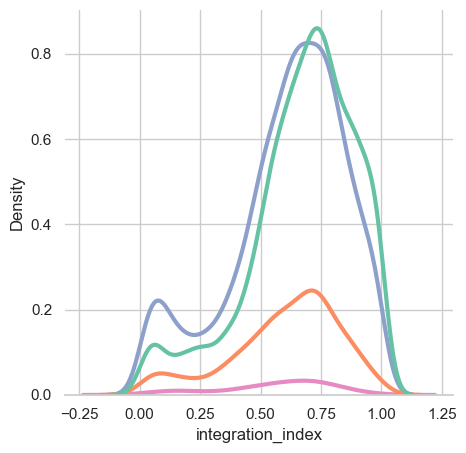

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette('Set2')

# 读取 CSV 数据
df = pd.read_csv(r'D:\Coding\segaration_research\user_mobility_seg.csv', encoding='utf-8')

# 过滤数据
vars = 'composite_integration_index'
q_low = df[vars].quantile(0.05)
q_hi = df[vars].quantile(0.95)
df_clean = df[(df[vars] > q_low) & (df[vars] < q_hi)]

# 使用 Seaborn 的 kdeplot 函数绘制 KDE 图
plt.figure(figsize=(5, 5))
g = sns.kdeplot(data=df_clean, 
            x='integration_index', 
            hue='age_label', 
            fill=False,
            palette=palette,
            alpha=1,
            legend=False,
            linewidth=3,
            )

# 去掉所有边框
# g.legend(frameon=False)
g.spines['top'].set_visible(False)
g.spines['left'].set_visible(False)
g.spines['right'].set_visible(False)
# plt.xlabel('Different Gender Experience Diversity', fontsize=16)
# plt.ylabel('Density', fontsize=16)
# 调整图例的位置
# g.legend(title='Age Label', loc='upper left')
# plt.savefig("D:/研究生/03Phd/segregation/figure/Density_gender.jpg", dpi=600, bbox_inches='tight')
plt.show()

<Figure size 500x500 with 0 Axes>

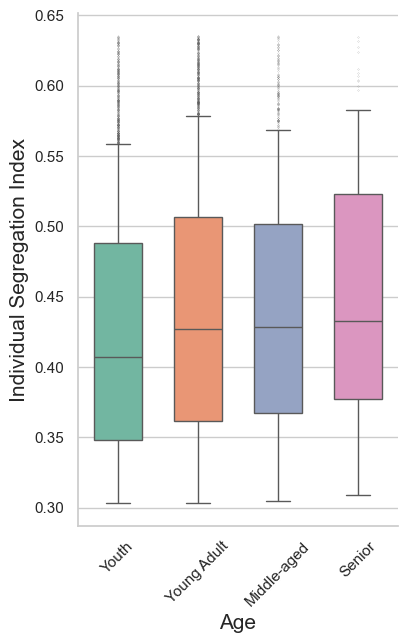

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette('Set2')

# 读取 CSV 数据
df = pd.read_csv(r'D:\Coding\segaration_research\user_mobility_exposure_seg.csv', encoding='utf-8')

# 过滤数据
vars = 'composite_integration_index'
q_low = df[vars].quantile(0.05)
q_hi = df[vars].quantile(0.95)
df_clean = df[(df[vars] > q_low) & (df[vars] < q_hi)]

# category_order = ['rich', 'medium', 'poor']
# df_clean['SES'] = pd.Categorical(df_clean['SES'], categories=category_order, ordered=True)

category_order = ['Youth', 'Young Adult', 'Middle-aged', 'Senior']
df_clean['age_label'] = pd.Categorical(df_clean['age_label'], categories=category_order, ordered=True)

plt.figure(figsize=(5, 5))
g = sns.catplot(
    data=df_clean, 
    kind='box',
    x="age_label", 
    y="composite_integration_index",  
    errorbar="ci", 
    # alpha=.8,
    height=6, 
    aspect=0.7,
    palette=palette,
    width=0.6,
    whis=0.5,
    fliersize=0.1,
    legend=False,
    # alpha=0.7
)

plt.xlabel('Age', fontsize=15)
plt.ylabel('Individual Segregation Index', fontsize=15)
# 调整图例的位置
# g.legend(title='Age Label', loc='upper left')
g.set_xticklabels(rotation=45)
g.despine(left=False)
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig8.jpg", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\浩然\AppData\Local\Temp\ipykernel_20032\2545851515.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SES'] = pd.Categorical(df_clean['SES'], categories=category_order, ordered=True)
C:\Users\浩然\AppData\Local\Temp\ipykernel_20032\2545851515.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age_label'] = pd.Categorical(df_clean['age_label'], categories=category_order, ordered=True)
C:\Users\浩然\AppData\Local\Temp\ipykernel_20032\2545851515.py:25: UserWarning: The palette list h

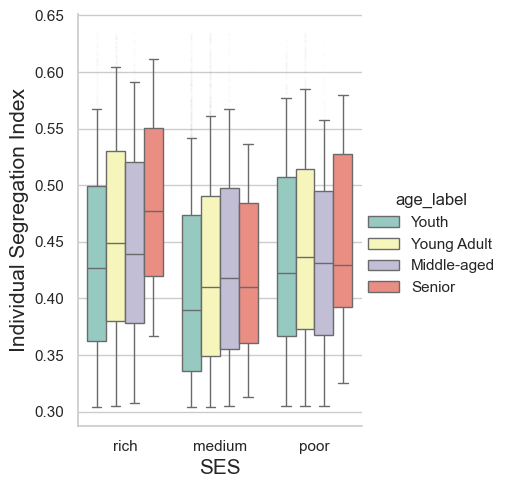

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取 CSV 数据
df = pd.read_csv(r'D:\Coding\segaration_research\user_mobility_exposure_seg.csv', encoding='utf-8')

# 过滤数据
vars = 'composite_integration_index'
q_low = df[vars].quantile(0.05)
q_hi = df[vars].quantile(0.95)
df_clean = df[(df[vars] > q_low) & (df[vars] < q_hi)]

# 设置类别顺序
category_order = ['rich', 'medium', 'poor']
df_clean['SES'] = pd.Categorical(df_clean['SES'], categories=category_order, ordered=True)
category_order = ['Youth', 'Young Adult', 'Middle-aged', 'Senior']
df_clean['age_label'] = pd.Categorical(df_clean['age_label'], categories=category_order, ordered=True)

# 绘图
sns.set_theme(style="whitegrid")
palette = sns.color_palette('Set3')
# custom_palette = [palette[4], palette[0]]  # 选择不同的颜色，例如第2和第3个颜色

g = sns.catplot(
    data=df_clean, 
    kind='box',
    x="SES", 
    y=vars,  
    hue="age_label",  # 添加这行来根据性别着色
    errorbar="ci", 
    height=5,
    aspect=0.8,
    palette=palette,
    width=0.8,
    whis=0.5,
    fliersize=0.01,
    legend=True  # 去掉图例
)

# 设置轴标签和旋转 x 轴标签
plt.xlabel('SES', fontsize=15)
plt.ylabel('Individual Segregation Index', fontsize=15)
# g.set_xticklabels(rotation=45)

# 去除左边框线
# g.despine(left=True)

# 保存图像
# plt.savefig("./EEI_POOR2.jpg", dpi=600, bbox_inches='tight')
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig9.jpg", dpi=600, bbox_inches='tight')
plt.show()

In [229]:
from scipy import stats
# 读取 CSV 数据
df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\user_differ.csv', encoding='gbk')

def anova_test(df, group_col, value_col):
    groups = df[group_col].unique()
    data = [df[df[group_col] == group][value_col] for group in groups]
    f_value, p_value = stats.f_oneway(*data)
    return f_value, p_value

# 使用示例（以性别为例）
f_value, p_value = anova_test(df, 'age_label', '≤1h')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

f_value, p_value = anova_test(df, 'SES', '≤1h')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

f_value, p_value = anova_test(df, 'gender', '≤1h')
print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

# f_value, p_value = anova_test(place_segregation_df, 'category', 'composite_integration_index')
# print(f"ANOVA结果：F值 = {f_value:.4f}, p值 = {p_value:.4f}")

ANOVA结果：F值 = 89.8234, p值 = 0.0000
ANOVA结果：F值 = 345.4291, p值 = 0.0000
ANOVA结果：F值 = 110.3798, p值 = 0.0000


## 空间自相关

In [24]:
import numpy as np
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from sklearn.neighbors import NearestNeighbors
from scipy import stats

def global_morans_i(df, column, k=5):
    coords = df[['lng', 'lat']].values
    knn = weights.KNN.from_array(coords, k=k)
    moran = esda.moran.Moran(df[column], knn)
    return moran

def custom_hot_spot_analysis(df, column, k=5, z_threshold=1.96, p_threshold=0.05):
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn.fit(df[['lng', 'lat']])
    distances, indices = nn.kneighbors(df[['lng', 'lat']])
    
    values = df[column].values
    local_sum = np.sum(values[indices[:, 1:]], axis=1)
    n = len(values)
    global_mean = np.mean(values)
    global_var = np.var(values)
    
    G = local_sum / (np.sum(values) - values)
    EG = k / (n - 1)
    VarG = (k * (n - 1 - k)) / ((n - 1)**2 * (n - 2))
    
    z_scores = (G - EG) / np.sqrt(VarG)
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    
    df = df.copy()
    df['z_score'] = z_scores
    df['p_value'] = p_values
    df['hotspot'] = np.where((df['z_score'] > z_threshold) & (df['p_value'] < p_threshold), 'Hot', 
                    np.where((df['z_score'] < -z_threshold) & (df['p_value'] < p_threshold), 'Cold', 'Not Significant'))
    return df


try:
    # 读取数据
    df = pd.read_csv(r'D:\Coding\segaration_research\place_mobility_exposure_seg.csv', encoding='utf-8')
    
    # 全局莫兰指数分析
    moran = global_morans_i(df, 'composite_integration_index')
    print(f"Global Moran's I: {moran.I}")
    print(f"p-value: {moran.p_sim}")
    
    # 热点分析
    result_df = custom_hot_spot_analysis(df, 'composite_integration_index')
    
    # 打印结果摘要
    print("\n热点分析结果:")
    print(result_df['hotspot'].value_counts())
    
    # 输出结果到CSV
    output_path = r'D:\Coding\segaration_research\analysis_results.csv'
    result_df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"\n分析结果已保存至: {output_path}")
    
except Exception as e:
    print(f"发生错误: {str(e)}")

Global Moran's I: 0.11006932263243868
p-value: 0.001

热点分析结果:
hotspot
Not Significant    4883
Name: count, dtype: int64

分析结果已保存至: D:\Coding\segaration_research\analysis_results.csv


## 双峰计算

C:\Users\浩然\AppData\Local\Temp\ipykernel_25040\3481253861.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax1 = sns.kdeplot(data=df['Non-EE'], label='Non-EE', palette=palette, linewidth=2)
C:\Users\浩然\AppData\Local\Temp\ipykernel_25040\3481253861.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax2 = sns.kdeplot(data=df['≤0.5h'], label='≤0.5h', palette=palette, linewidth=2)
C:\Users\浩然\AppData\Local\Temp\ipykernel_25040\3481253861.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax3 = sns.kdeplot(data=df['≤1h'], label='≤1h', palette=palette, linewidth=2)
C:\Users\浩然\AppData\Local\Temp\ipykernel_25040\3481253861.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax4 = sns.kdeplot(data=df['≤2h'], label='≤2h', palette=palette, linewidth=2)
C:\Users\浩然\AppData\Local\Temp\ipykernel_25040\3481253861.py:20: UserWarning: Ignoring `palette` because n

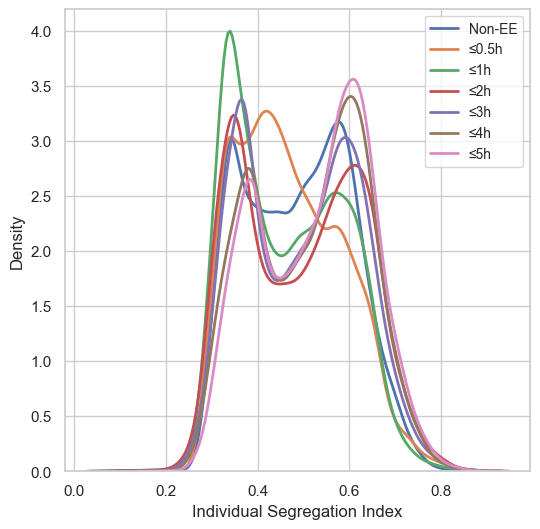

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\user_differ.csv', encoding='gbk')


# 设置图表样式
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
palette = sns.color_palette('Set3')

# 绘制密度图
ax1 = sns.kdeplot(data=df['Non-EE'], label='Non-EE', palette=palette, linewidth=2)
ax2 = sns.kdeplot(data=df['≤0.5h'], label='≤0.5h', palette=palette, linewidth=2)
ax3 = sns.kdeplot(data=df['≤1h'], label='≤1h', palette=palette, linewidth=2)
ax4 = sns.kdeplot(data=df['≤2h'], label='≤2h', palette=palette, linewidth=2)
ax5 = sns.kdeplot(data=df['≤3h'], label='≤3h', palette=palette, linewidth=2)
ax6 = sns.kdeplot(data=df['≤4h'], label='≤4h', palette=palette, linewidth=2)
ax7 = sns.kdeplot(data=df['≤5h'], label='≤5h', palette=palette, linewidth=2)


# user_median = df['Experiential Exposures'].median()
# ax1.axvline(user_median, color='tab:blue', linestyle='--', linewidth=2, alpha=0.5)

# user_median2 = df['Non-Experiential Exposures'].median()
# ax2.axvline(user_median2, color='tab:orange', linestyle='--', linewidth=2, alpha=0.5)

# # 设置图表标题和标签
plt.xlabel('Individual Segregation Index', fontsize=12)
plt.legend(fontsize=10)
# plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig14.jpg", dpi=600, bbox_inches='tight')
# 显示图表
plt.show()

In [40]:
user_median, user_median2

(0.419422608, 0.4898551785)

In [247]:
import pandas as pd
import io

# 假设您的CSV数据存储在一个名为'data.csv'的文件中
# 如果数据是直接作为字符串提供的,您可以使用io.StringIO()来创建一个类文件对象

# 读取CSV数据
df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ.csv', encoding='gbk')  # 使用制表符作为分隔符

# 将宽数据转换为长数据
df_long = pd.melt(df, 
                  id_vars=['place', 'category'],
                  value_vars=['Non-EE', '≤0.5h', '≤1h', '≤2h', '≤3h', '≤4h', '≤5h'],
                  var_name='exposure_time',
                  value_name='exposure_value')

# 重新排列列的顺序
df_long = df_long[['place', 'category', 'exposure_value', 'exposure_time']]

# 将结果保存为新的CSV文件
df_long.to_csv(r'D:\研究生\03Phd\segregation\data\place_differ_long.csv', index=False, encoding='gbk')

# 打印前几行来验证结果
print(df_long.head())

                     place                                      category  \
0  LAB whisky&amp;cocktail                               Dining Services   
1                  上海公安博物馆  Government Agencies and Social Organizations   
2                 外滩万国建筑博览                          Commercial Buildings   
3                    威尼斯小镇                             Shopping Services   
4                     玉佛禅寺                           Tourist Attractions   

   exposure_value exposure_time  
0        0.282311        Non-EE  
1        0.574329        Non-EE  
2        0.848721        Non-EE  
3        0.629291        Non-EE  
4        0.622075        Non-EE  


In [2]:
print(df.columns)

Index(['user_id,Experiential Exposures,Non-Experiential Exposures,gender,age_label,SES'], dtype='object')


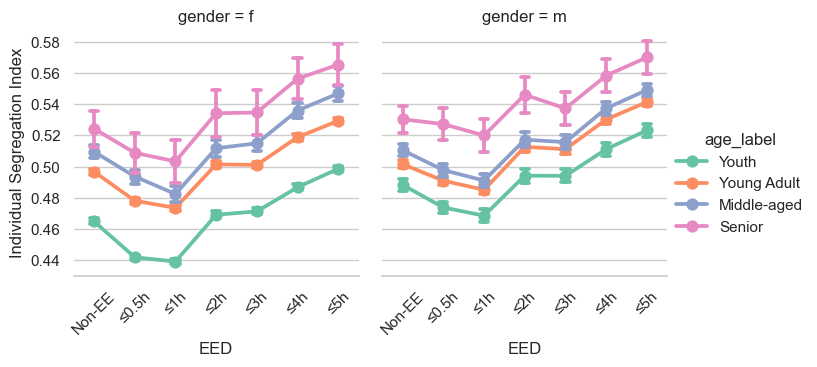

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

df_long = pd.read_csv(r'D:\研究生\03Phd\segregation\data\user_differ_long.csv', encoding='gbk')  # 使用制表符作为分隔符
# Load the example exercise dataset
# exercise = sns.load_dataset("exercise")

# 设置类别顺序
category_order = ['Youth', 'Young Adult', 'Middle-aged', 'Senior']
df_long['age_label'] = pd.Categorical(df_long['age_label'], categories=category_order, ordered=True)

# category_order = ['rich', 'medium', 'poor']
# df_long['SES'] = pd.Categorical(df_long['SES'], categories=category_order, ordered=True)

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df_long, x="exposure_time", y="exposure_value", col="gender", hue='age_label',
    capsize=.2, palette="Set2", errorbar="se",
    kind="point", height=3.5, aspect=1,
)
g.despine(left=True)
# plt.xlabel('Exposure Type', fontsize=15)
# plt.ylabel('Individual Segregation Index', fontsize=15)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("EED", "Individual Segregation Index", fontsize=12)
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\user_seg2.jpg", dpi=600, bbox_inches='tight')
plt.show()

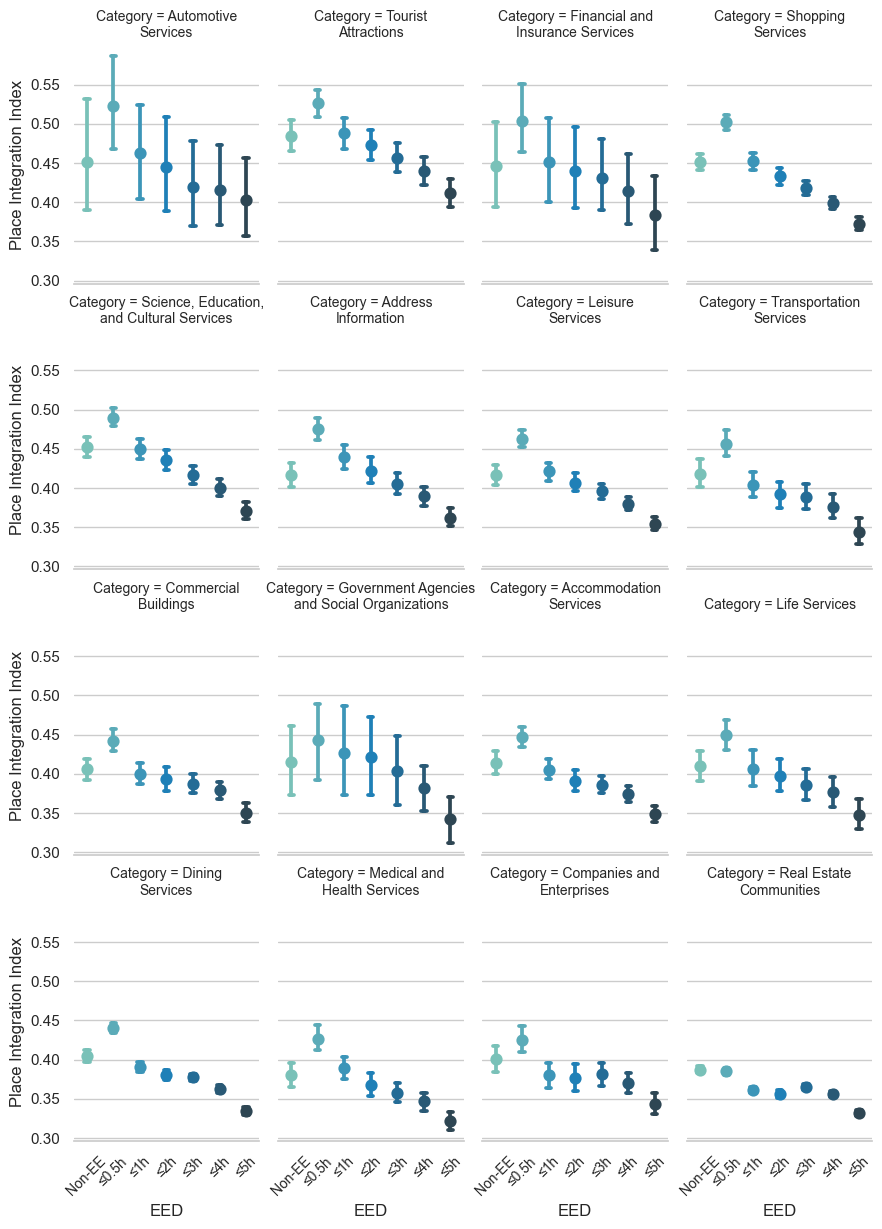

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

df_long = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ_long.csv', encoding='gbk')  # 使用制表符作为分隔符

# 设置类别顺序
category_order = ['Automotive Services', 'Tourist Attractions',  'Financial and Insurance Services', 'Shopping Services','Science, Education, and Cultural Services',
                  'Address Information',  'Leisure Services',  'Transportation Services',
                'Commercial Buildings', 'Government Agencies and Social Organizations', 'Accommodation Services', 'Life Services', 'Dining Services', 'Medical and Health Services', 
                   'Companies and Enterprises', 'Real Estate Communities']
df_long['category'] = pd.Categorical(df_long['category'], categories=category_order, ordered=True)


# 创建图表
g = sns.catplot(
    data=df_long, x="exposure_time", y="exposure_value", col='category', 
    capsize=.2, palette="YlGnBu_d", errorbar="ci", estimator='mean',
    kind="point", height=3, aspect=.75,
    col_wrap=4
)

# 去掉左边的脊柱
g.despine(left=True)

# 添加换行符，调整标签
new_labels = [
    "Category = Automotive\nServices",
    "Category = Tourist\nAttractions",
    "Category = Financial and\nInsurance Services",
    "Category = Shopping\nServices",
    "Category = Science, Education,\nand Cultural Services",
    "Category = Address\nInformation",
    "Category = Leisure\nServices",
    "Category = Transportation\nServices",
    "Category = Commercial\nBuildings",
    "Category = Government Agencies\nand Social Organizations",
    "Category = Accommodation\nServices",
    "Category = Life Services",
    "Category = Dining\nServices",
    "Category = Medical and\nHealth Services",
    "Category = Companies and\nEnterprises",
    "Category = Real Estate\nCommunities"
]

for ax, label in zip(g.axes.flat, new_labels):
    ax.set_title(label, fontsize=10)
    ax.set_xlabel("EED", fontsize=12)  # 设置x轴标签
    ax.set_ylabel("Place Integration Index", fontsize=12)  # 设置y轴标签
# 调整每个子图的标签字体大小和旋转角度
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_fontsize(10)
# 调整子图之间的间距
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\place_inte.jpg", dpi=600, bbox_inches='tight')
plt.show()

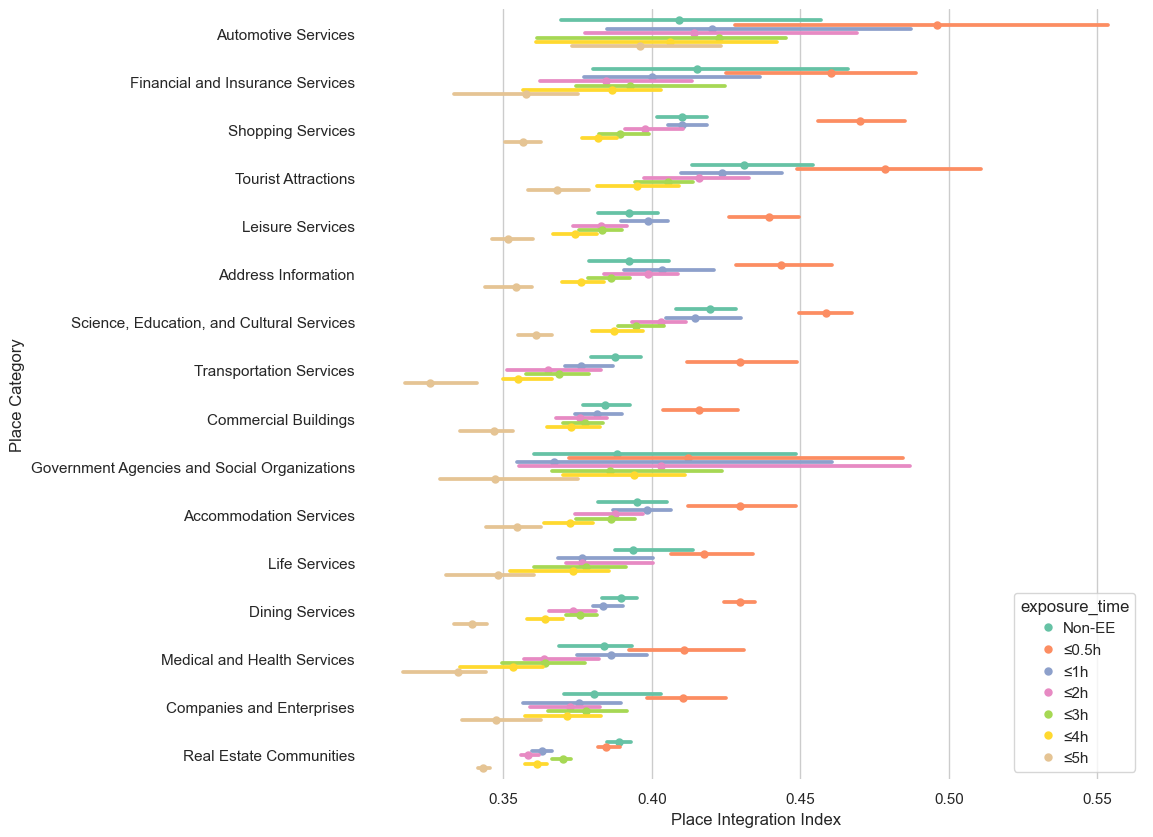

In [536]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_long = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ_long.csv', encoding='gbk')  # 使用制表符作为分隔符
sns.set_theme(style="whitegrid")

# 设置类别顺序
category_order = ['Automotive Services', 'Financial and Insurance Services', 'Shopping Services', 'Tourist Attractions', 'Leisure Services',  
                  'Address Information',  'Science, Education, and Cultural Services', 'Transportation Services',
                'Commercial Buildings', 'Government Agencies and Social Organizations', 'Accommodation Services', 'Life Services', 'Dining Services', 'Medical and Health Services', 
                   'Companies and Enterprises', 'Real Estate Communities']
df_long['category'] = pd.Categorical(df_long['category'], categories=category_order, ordered=True)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))  # 或者任何您想要的尺寸
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# sns.stripplot(
#     data=df_long, x="exposure_value", y="category", hue="exposure_type",
#     dodge=True, alpha=.25, zorder=1, legend=False, palette="Set2", 
# )

sns.pointplot(
    data=df_long, x="exposure_value", y="category", hue="exposure_time",
    dodge=.8 - .8 / 3,  palette="Set2", errorbar='ci',
    markers="o", markersize=4, linestyle="none", estimator='median'
)

# Improve the legend
sns.move_legend(
    ax, loc="lower right", ncol=1, frameon=True, columnspacing=1, handletextpad=0,
)

plt.xlabel('Place Integration Index', fontsize=12)
plt.ylabel('Place Category', fontsize=12)
# plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig16.jpg", dpi=600, bbox_inches='tight')
plt.show()

## palce & user

In [253]:
import pandas as pd

# 读取 a 和 b 数据
a_data = pd.read_csv(r'D:\研究生\03Phd\segregation\data\user_differ.csv', encoding='gbk')
b_data = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_user_compare.csv', encoding='gbk')

# 将 a_data 中的 user_id 和 Experiential Exposures 转换为字典
exposure_dict = dict(zip(a_data['user_id'], a_data['≤1h']))

# 在 b_data 中添加新列 Experiential Exposures
b_data['Experiential Exposures'] = b_data['user_id'].map(exposure_dict)

# 将更新后的 b_data 保存为新的 CSV 文件
b_data.to_csv(r'D:\研究生\03Phd\segregation\data\place_user_compare.csv', encoding='gbk', index=False)

print("数据更新完成，已保存为 'updated_b_data.csv'")

数据更新完成，已保存为 'updated_b_data.csv'


In [256]:
# 计算每个地点的平均 Experiential Exposures
mean_exposures = b_data.groupby('place')['Experiential Exposures'].mean()
mean_exposures.to_csv(r'D:\研究生\03Phd\segregation\data\place_user_compare_ISI.csv', encoding='gbk', index=False)

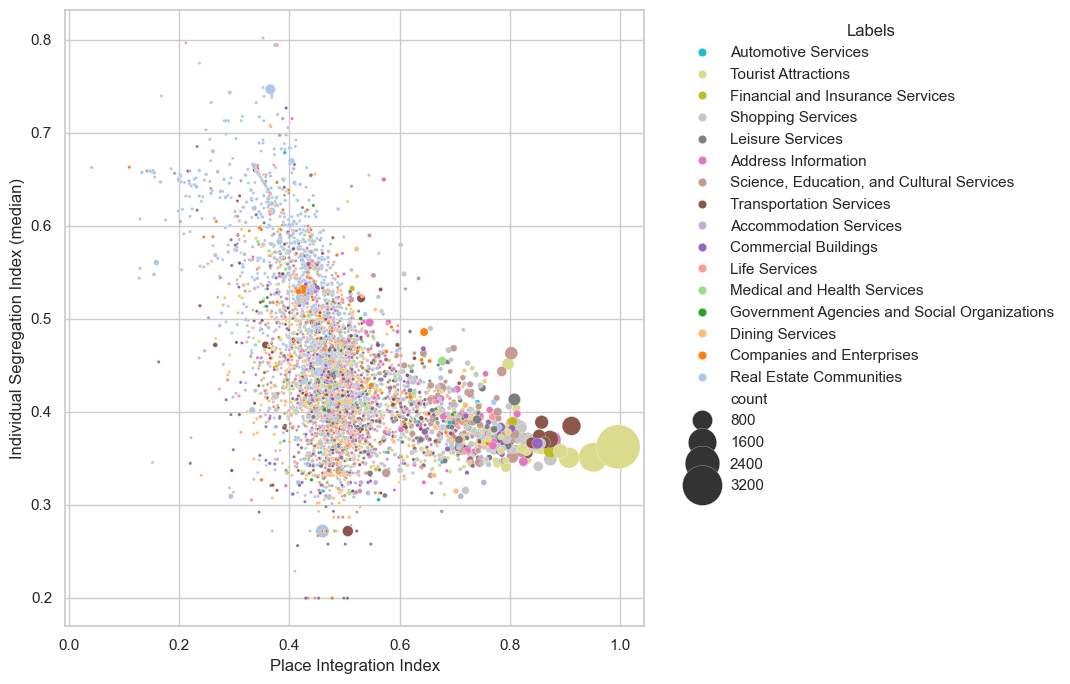

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ.csv', encoding='gbk')
# filtered_result = df[df['count'] >= 200]

palette = sns.color_palette("tab20_r", 16)
sns.set_theme(style="whitegrid")

# 绘制散点图
plt.figure(figsize=(11, 7))
sns.despine(bottom=True, left=True)

category_order = ['Automotive Services', 'Tourist Attractions',  'Financial and Insurance Services', 'Shopping Services','Science, Education, and Cultural Services',
                  'Address Information',  'Leisure Services',  'Transportation Services',
                'Commercial Buildings', 'Government Agencies and Social Organizations', 'Accommodation Services', 'Life Services', 'Dining Services', 'Medical and Health Services', 
                   'Companies and Enterprises', 'Real Estate Communities']
df_long['category'] = pd.Categorical(df_long['category'], categories=category_order, ordered=True)

scatter = sns.scatterplot(
    data=df,
    x='Experiential Exposures',
    y='user_segregation',
    size='count',
    hue='category',
    palette=palette,
    sizes=(5, 1000),
    # alpha=0.8,
    # legend='full'
    
)

# 添加标题和标签
# plt.title('Scatter Plot of Experience Segregation Mean vs Variance (Count >= 500)')
plt.xlabel('Place Integration Index', fontsize=12)
plt.ylabel('Individual Segregation Index (median)', fontsize=12)

# 调整图例位置
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles[1:], labels=labels[1:], title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# 显示图表
plt.tight_layout()
# plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig17.jpg", dpi=600, bbox_inches='tight')
plt.show()

Text(33.28125, 0.5, 'Individual Segregation Index (median)')

<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 0 Axes>

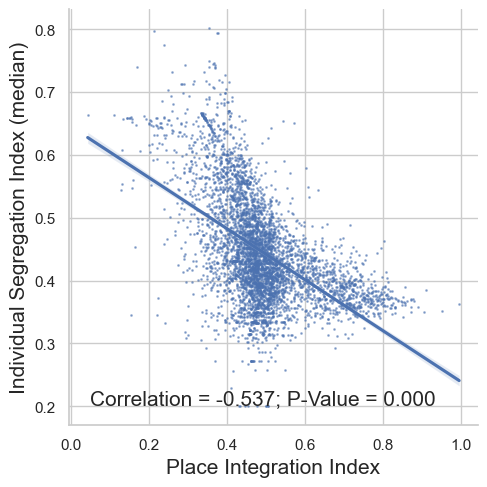

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

sns.set_theme(style="whitegrid")
sns.despine(bottom=True, left=True)
plt.figure(figsize=(5, 5))

df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ.csv', encoding='gbk')
correlation, p_value = stats.pearsonr(df['Experiential Exposures'], df['user_segregation'])

g = sns.lmplot(
    data=df,
    x='Experiential Exposures',
    y='user_segregation', 
    scatter_kws={"s": 1, "alpha": 0.5},
)

# 在图上添加相关系数
plt.text(0.05, 0.05, f'Correlation = {correlation:.3f}; P-Value = {p_value:.3f}', 
         transform=plt.gca().transAxes, fontsize=15)

plt.xlabel('Place Integration Index', fontsize=15)
plt.ylabel('Individual Segregation Index (median)', fontsize=15)
# plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig18.jpg", dpi=600, bbox_inches='tight')

In [34]:
from scipy import stats
df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\place_differ.csv', encoding='gbk')
correlation, p_value = stats.pearsonr(df['Experiential Exposures'], df['user_segregation'])
print(f"皮尔森相关系数: {correlation:.4f}")
print(f"p 值: {p_value:.4f}")

# 判断显著性
alpha = 0.05  # 设置显著性水平，通常为 0.05
if p_value < alpha:
    print("相关性统计显著")
else:
    print("相关性统计不显著")

皮尔森相关系数: -0.5365
p 值: 0.0000
相关性统计显著


## 相关性分析

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.utils import resample

# 读取数据
# 假设您的数据已经保存为CSV文件，请替换为您的文件路径
data = pd.read_csv(r'D:\研究生\03Phd\segregation\data\social_eco.csv', encoding='gbk')

# 尝试将所有列转换为数值型
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# 计算相关系数、p值和置信区间
def calculate_correlation_with_ci(x, y, n_bootstrap=200, ci=0.95):
    corr, p_value = pearsonr(x, y)
    
    # Bootstrap for confidence interval
    bootstrap_correlations = []
    for _ in range(n_bootstrap):
        x_resampled, y_resampled = resample(x, y)
        bootstrap_corr, _ = pearsonr(x_resampled, y_resampled)
        bootstrap_correlations.append(bootstrap_corr)
    
    ci_lower = np.percentile(bootstrap_correlations, (1 - ci) / 2 * 100)
    ci_upper = np.percentile(bootstrap_correlations, (1 + ci) / 2 * 100)
    
    return corr, p_value, ci_lower, ci_upper

# 创建相关性、p值和置信区间矩阵
columns = data.columns
corr_matrix = pd.DataFrame(index=columns, columns=columns)
p_matrix = pd.DataFrame(index=columns, columns=columns)
ci_lower_matrix = pd.DataFrame(index=columns, columns=columns)
ci_upper_matrix = pd.DataFrame(index=columns, columns=columns)

for i in columns:
    for j in columns:
        corr, p, ci_lower, ci_upper = calculate_correlation_with_ci(data[i], data[j])
        corr_matrix.loc[i, j] = corr
        p_matrix.loc[i, j] = p
        ci_lower_matrix.loc[i, j] = ci_lower
        ci_upper_matrix.loc[i, j] = ci_upper

# 创建带星号和置信区间的相关系数矩阵
def add_stars_and_ci(value, p, ci_lower, ci_upper):
    stars = ""
    if p <= 0.001:
        stars = "***"
    elif p <= 0.01:
        stars = "**"
    elif p <= 0.05:
        stars = "*"
    
    return f"{value:.2f}{stars}\n[{ci_lower:.2f}, {ci_upper:.2f}]"

stars_ci_matrix = pd.DataFrame(index=columns, columns=columns)
for i in columns:
    for j in columns:
        stars_ci_matrix.loc[i, j] = add_stars_and_ci(
            corr_matrix.loc[i, j],
            p_matrix.loc[i, j],
            ci_lower_matrix.loc[i, j],
            ci_upper_matrix.loc[i, j]
        )

# 保存结果到CSV
stars_ci_matrix.to_csv('correlation_results.csv')

# # 创建热图
# plt.figure(figsize=(20, 16))
# sns.heatmap(corr_matrix, annot=stars_matrix, fmt='', cmap='coolwarm', vmin=-1, vmax=1, center=0)
# plt.title('Pearson Correlation with Significance Levels', fontsize=16)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
# plt.close()

# print("相关性分析完成。结果已保存到 'correlation_results.csv' 文件中，热图已保存为 'correlation_heatmap.png'。")

In [15]:
stars_ci_matrix

,Place Integration,"Permanent resident population at year-end (10,000 persons)","Non-local population (10,000 persons)",Population density (persons/km),Inflow from outside the city (persons),Outflow to outside the city (persons),"17 years old and below (10,000 persons)","18 to 34 years old (10,000 persons)","35 to 59 years old (10,000 persons)","60 years old and above (10,000 persons)",...,Urban park area (hectares),"Park visitors (10,000 person-times)",Total industrial output value (100 million yuan),Total construction output value (100 million yuan),Total service industry profit (100 million yuan),GDP (100 million yuan),GDP per capita (yuan),Primary industry gross output value (100 million yuan),Secondary industry gross output value (100 million yuan),Tertiary industry gross output value (100 million yuan)
Place Integration,"1.00***\n[1.00, 1.00]","-0.69**\n[-0.87, -0.53]","-0.71**\n[-0.85, -0.61]","0.75**\n[0.36, 0.93]","-0.43\n[-0.71, -0.13]","-0.02\n[-0.38, 0.41]","-0.28\n[-0.60, 0.17]","-0.14\n[-0.49, 0.30]","-0.33\n[-0.61, 0.25]","0.12\n[-0.32, 0.66]",...,"-0.64**\n[-0.86, -0.22]","0.10\n[-0.28, 0.47]","-0.70**\n[-0.86, -0.60]","-0.04\n[-0.53, 0.54]","0.57*\n[-0.17, 0.88]","0.12\n[-0.29, 0.67]","0.61*\n[0.37, 0.91]","-0.03\n[-0.49, 0.38]","-0.61*\n[-0.83, -0.42]","0.44\n[0.03, 0.83]"
"Permanent resident population at year-end (10,000 persons)","-0.69**\n[-0.88, -0.54]","1.00***\n[1.00, 1.00]","0.93***\n[0.88, 0.97]","-0.39\n[-0.77, -0.03]","0.88***\n[0.70, 0.97]","0.34\n[0.02, 0.79]","0.79***\n[0.40, 0.92]","0.63*\n[0.20, 0.87]","0.76**\n[0.37, 0.91]","0.32\n[-0.16, 0.70]",...,"0.67**\n[0.14, 0.88]","0.27\n[-0.36, 0.62]","0.77***\n[0.57, 0.89]","0.43\n[-0.26, 0.76]","-0.12\n[-0.50, 0.51]","0.31\n[-0.24, 0.74]","-0.50\n[-0.76, -0.16]","-0.33\n[-0.65, 0.09]","0.67**\n[0.46, 0.86]","-0.08\n[-0.61, 0.49]"
"Non-local population (10,000 persons)","-0.71**\n[-0.84, -0.59]","0.93***\n[0.87, 0.97]","1.00***\n[1.00, 1.00]","-0.54*\n[-0.89, -0.17]","0.78***\n[0.46, 0.91]","0.22\n[-0.24, 0.82]","0.58*\n[0.06, 0.85]","0.37\n[-0.15, 0.72]","0.51\n[-0.15, 0.81]","-0.01\n[-0.56, 0.50]",...,"0.56*\n[0.13, 0.87]","0.00\n[-0.51, 0.51]","0.90***\n[0.79, 0.97]","0.16\n[-0.49, 0.63]","-0.14\n[-0.49, 0.45]","0.28\n[-0.34, 0.73]","-0.44\n[-0.73, -0.11]","-0.26\n[-0.55, 0.30]","0.76***\n[0.52, 0.93]","-0.17\n[-0.57, 0.26]"
Population density (persons/km),"0.75**\n[0.38, 0.94]","-0.39\n[-0.74, 0.04]","-0.54*\n[-0.91, -0.21]","1.00***\n[1.00, 1.00]","-0.12\n[-0.60, 0.44]","0.16\n[-0.27, 0.59]","0.11\n[-0.27, 0.59]","0.21\n[-0.17, 0.68]","-0.01\n[-0.40, 0.51]","0.53*\n[0.15, 0.81]",...,"-0.37\n[-0.80, 0.04]","0.62*\n[0.25, 0.88]","-0.72**\n[-0.92, -0.51]","0.40\n[-0.02, 0.82]","0.49\n[-0.02, 0.77]","0.36\n[-0.09, 0.78]","0.62*\n[0.41, 0.88]","-0.53*\n[-0.81, -0.09]","-0.62*\n[-0.89, -0.30]","0.71**\n[0.40, 0.92]"
Inflow from outside the city (persons),"-0.43\n[-0.69, -0.09]","0.88***\n[0.67, 0.96]","0.78***\n[0.31, 0.91]","-0.12\n[-0.52, 0.41]","1.00***\n[1.00, 1.00]","0.60*\n[0.41, 0.89]","0.90***\n[0.72, 0.97]","0.81***\n[0.54, 0.93]","0.80***\n[0.45, 0.93]","0.45\n[0.09, 0.75]",...,"0.46\n[0.10, 0.88]","0.42\n[-0.08, 0.78]","0.59*\n[0.25, 0.83]","0.41\n[-0.07, 0.77]","0.07\n[-0.29, 0.72]","0.53*\n[-0.03, 0.88]","-0.27\n[-0.59, 0.19]","-0.44\n[-0.68, -0.07]","0.56*\n[0.08, 0.84]","0.22\n[-0.20, 0.64]"
Outflow to outside the city (persons),"-0.02\n[-0.36, 0.50]","0.34\n[0.05, 0.76]","0.22\n[-0.23, 0.80]","0.16\n[-0.19, 0.62]","0.60*\n[0.42, 0.91]","1.00***\n[1.00, 1.00]","0.57*\n[0.40, 0.89]","0.72**\n[0.49, 0.92]","0.48\n[0.27, 0.83]","0.42\n[-0.19, 0.77]",...,"0.22\n[-0.15, 0.68]","0.30\n[-0.19, 0.70]","0.17\n[-0.32, 0.64]","0.27\n[-0.12, 0.73]","0.10\n[-0.31, 0.89]","0.33\n[0.06, 0.68]","-0.07\n[-0.44, 0.63]","-0.17\n[-0.56, 0.44]","0.17\n[-0.24, 0.63]","0.22\n[-0.20, 0.76]"
"17 years old and below (10,000 persons)","-0.28\n[-0.55, 0.30]","0.79***\n[0.43, 0.91]","0.58*\n[0.13, 0.87]","0.11\n[-0.32, 0.57]","0.90***\n[0.72, 0.97]","0.57*\n[0.40,

<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 0 Axes>

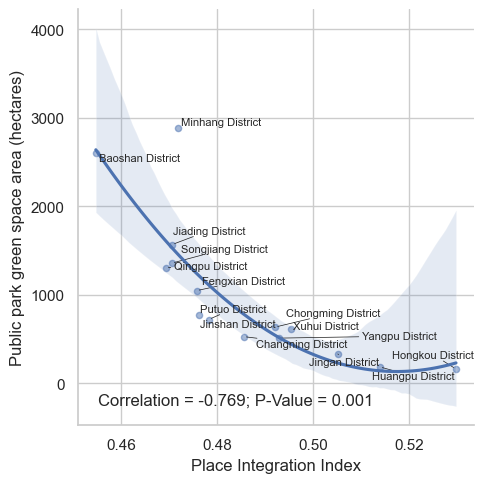

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from adjustText import adjust_text

sns.set_theme(style="whitegrid")
sns.despine(bottom=True, left=True)
plt.figure(figsize=(5, 5))

x_v = 'Public park green space area (hectares)'

df = pd.read_csv(r'D:\研究生\03Phd\segregation\data\social_eco.csv', encoding='gbk')
correlation, p_value = stats.pearsonr(df['Place Integration'], df[x_v])

# 创建图表
g = sns.lmplot(
    data=df,
    x='Place Integration',
    y= x_v,
    order=2, 
    scatter_kws={"s": 20, "alpha": 0.5},
)

# 获取当前的轴对象
ax = plt.gca()

# ax.set_ylim(bottom=0)

# 准备文本标签
texts = []
for idx, row in df.iterrows():
    texts.append(ax.text(row['Place Integration'], 
                         row[x_v], 
                         row['District'],
                         fontsize=8))

# 使用 adjust_text 调整文本位置
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))

# 在图上添加相关系数
plt.text(0.05, 0.05, f'Correlation = {correlation:.3f}; P-Value = {p_value:.3f}', 
         transform=plt.gca().transAxes, fontsize=12)

plt.xlabel('Place Integration Index', fontsize=12)
plt.ylabel(x_v, fontsize=12)
plt.savefig(r"D:\研究生\03Phd\segregation\shanghai\fig24.jpg", dpi=600, bbox_inches='tight')

In [ ]:
# # 创建带星号的相关系数矩阵
# def add_stars(value, p):
#     if p <= 0.001:
#         return f"{value:.2f}***"
#     elif p <= 0.01:
#         return f"{value:.2f}**"
#     elif p <= 0.05:
#         return f"{value:.2f}*"
#     else:
#         return f"{value:.2f}"